### Библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

import sys
sys.path.append('../data')

### Данные

In [2]:
raw_data = pd.read_excel('../data/Project 2_2023.xlsx', sheet_name='Data')
raw_data = raw_data.rename(columns={'Date':'Timestamp'})
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'])
raw_data.isna().sum() # пропусков нет

Timestamp    0
Income       0
Outcome      0
Balance      0
dtype: int64

In [3]:
# приводим к формату даты
assert pd.to_datetime(raw_data['Timestamp']).dt.hour.unique() == np.array([0]), "указывается часы"
assert pd.to_datetime(raw_data['Timestamp']).dt.minute.unique() == np.array([0]), "указывается минуты"
assert pd.to_datetime(raw_data['Timestamp']).dt.second.unique() == np.array([0]), "указывается секунды"

raw_data['Date'] = pd.to_datetime(raw_data['Timestamp']).dt.date
data = raw_data.copy()

### Визуализация

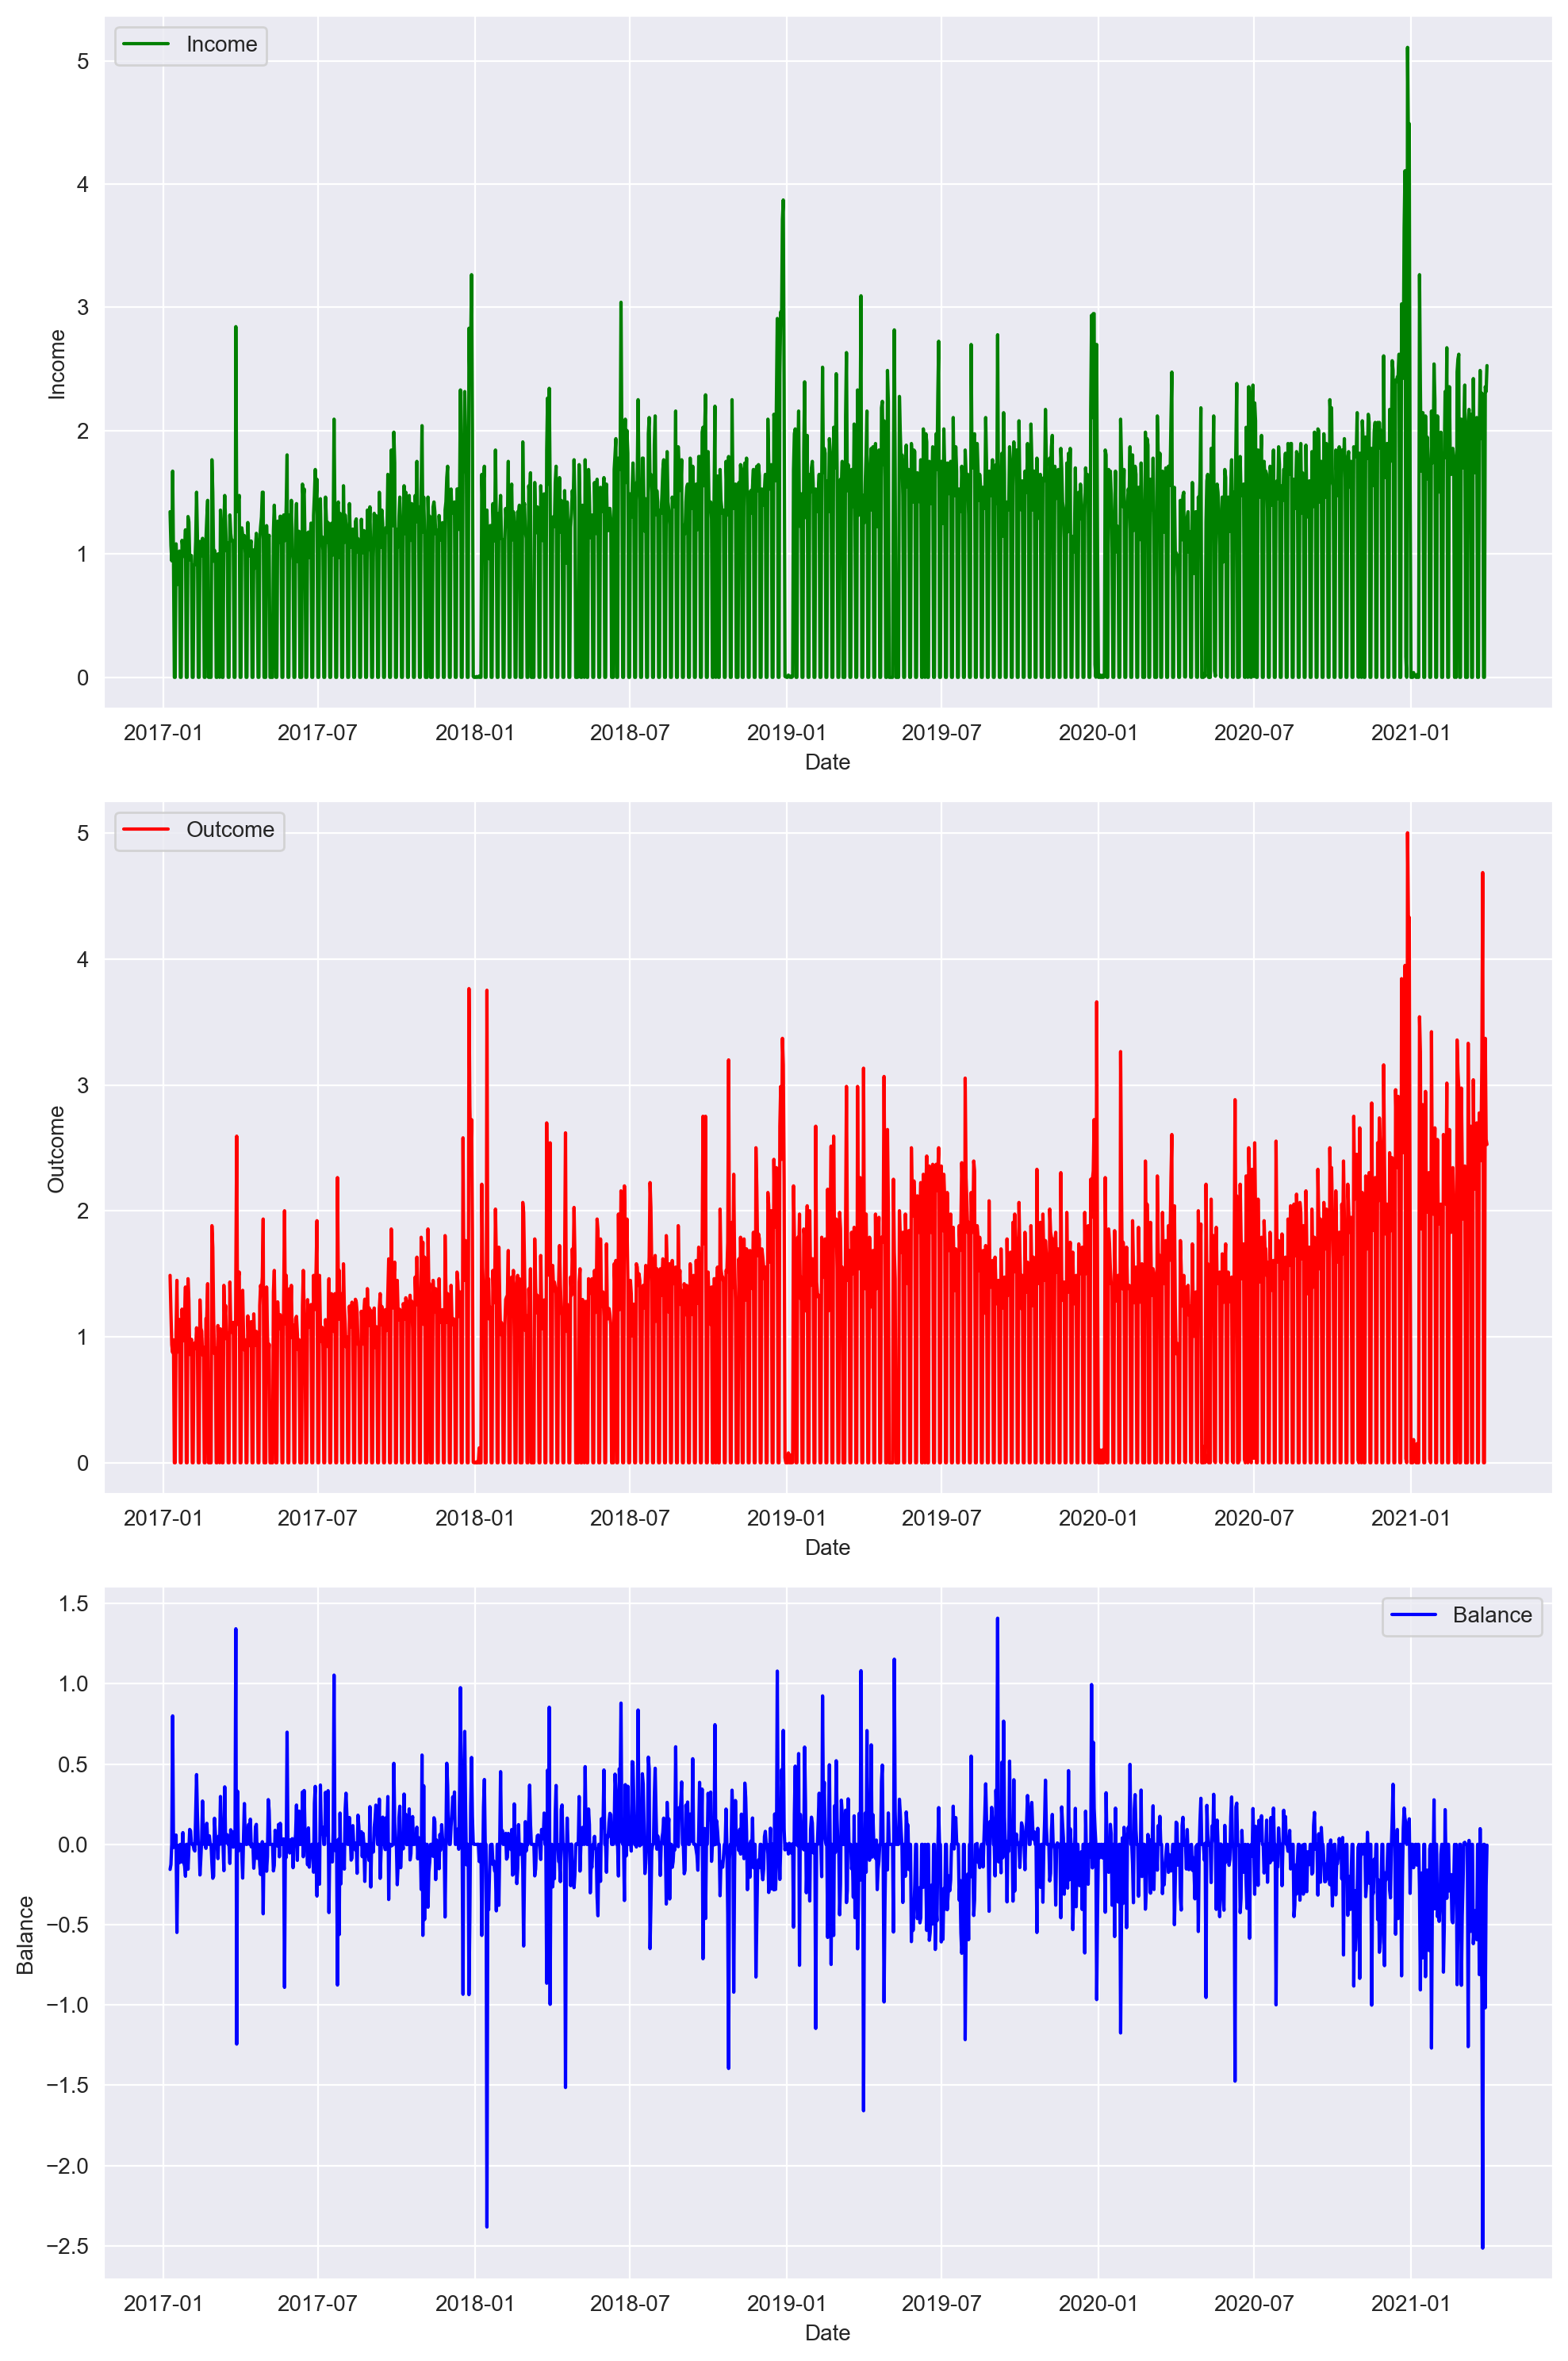

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(data=data, x='Date', y='Income', ax=ax1, color='green', label='Income')


sns.lineplot(data=data, x='Date', y='Outcome', ax=ax2, color='red', label='Outcome')


sns.lineplot(data=data, x='Date', y='Balance', ax=ax3, color='blue', label='Balance')

plt.tight_layout()
plt.show()

__Выводы:__

* На первом и втором графике видны регулрные нулевые значения, причем одновременно на income и outcome
* На третьем графике заметен перевес в сторону отрицательного баланса с 2020 гола (в 2021 году еще сильнее)

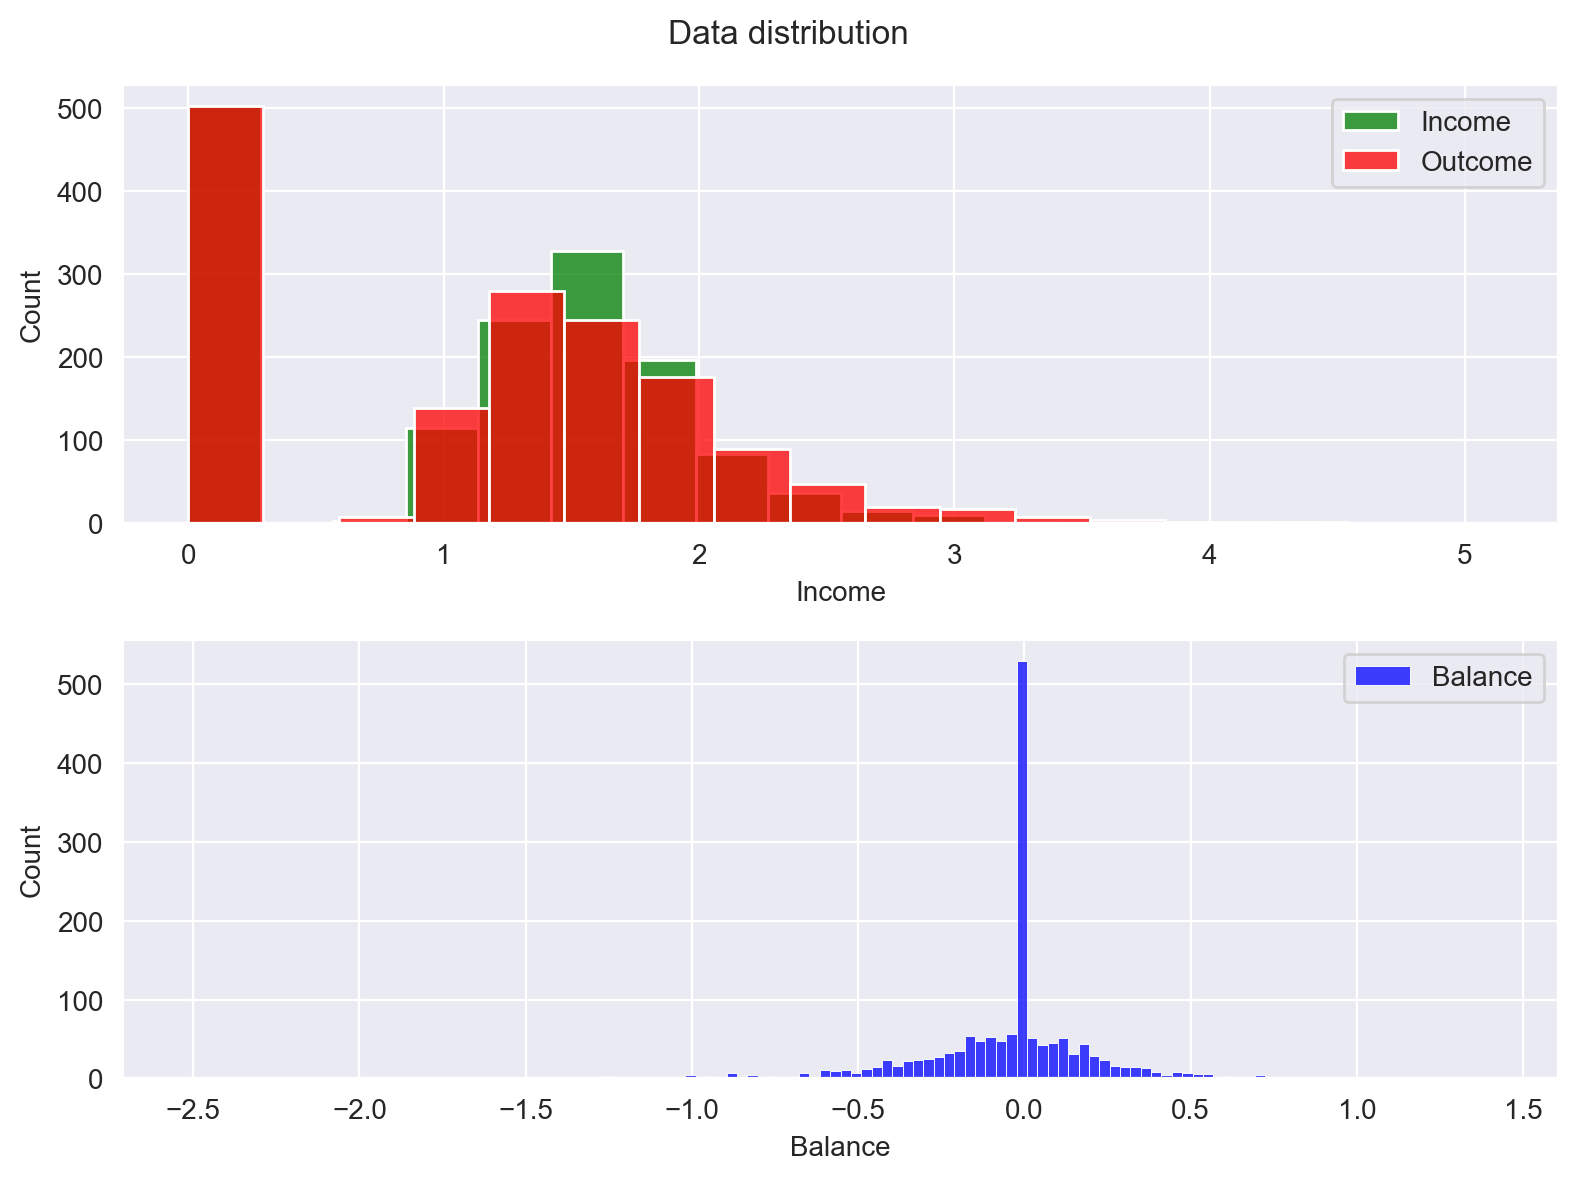

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(data=data, x='Income', ax=ax1, color='green', label='Income')
sns.histplot(data=data, x='Outcome', ax=ax1, color='red', label='Outcome')
ax1.legend()

sns.histplot(data=data, x='Balance', ax=ax2, color='blue', label='Balance')
ax2.legend()

plt.suptitle('Data distribution')
plt.tight_layout()
plt.show()

__Выводы:__

* Примерно одинаковое кол-во нулей у income и outcome
* Balance имеет тяжелые хвосты

### Учет календарной информации

In [6]:
data['week_day'] = data['Timestamp'].dt.day_of_week

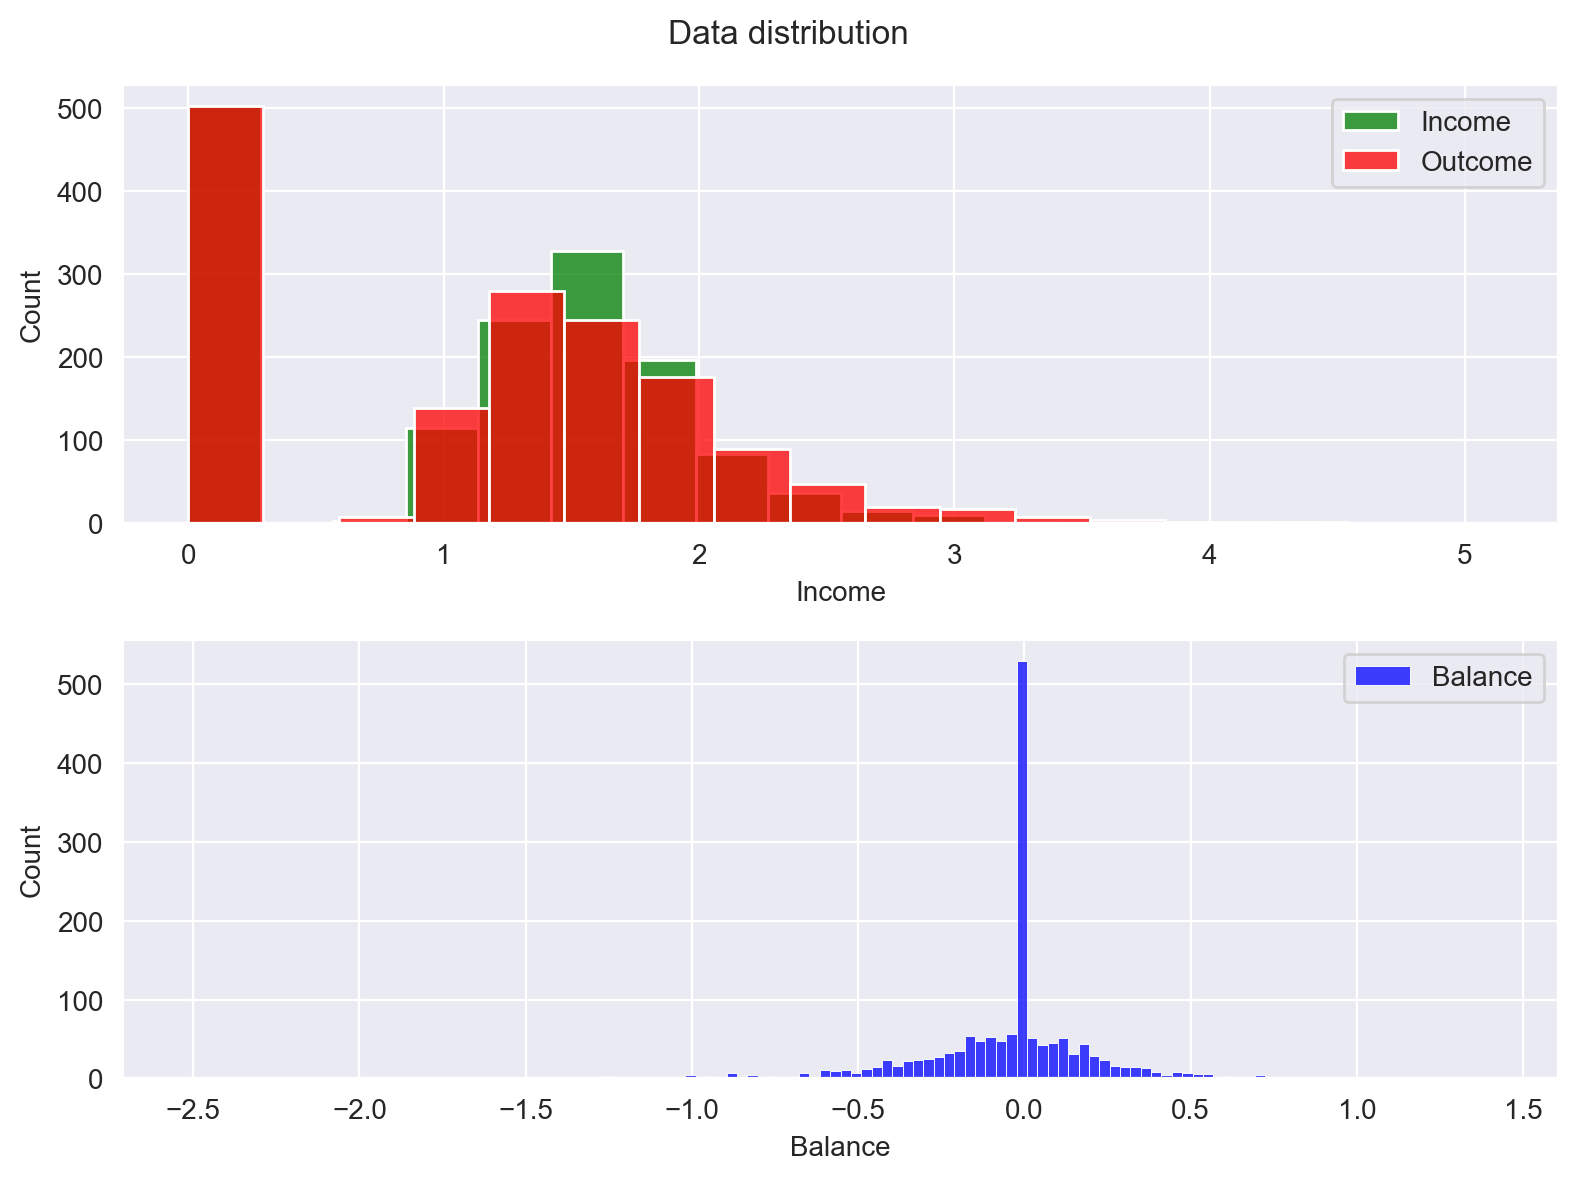

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(data=data, x='Income', ax=ax1, color='green', label='Income')
sns.histplot(data=data, x='Outcome', ax=ax1, color='red', label='Outcome')
ax1.legend()

sns.histplot(data=data, x='Balance', ax=ax2, color='blue', label='Balance')
ax2.legend()

plt.suptitle('Data distribution')
plt.tight_layout()
plt.show()

<Axes: xlabel='week_day_name', ylabel='Count'>

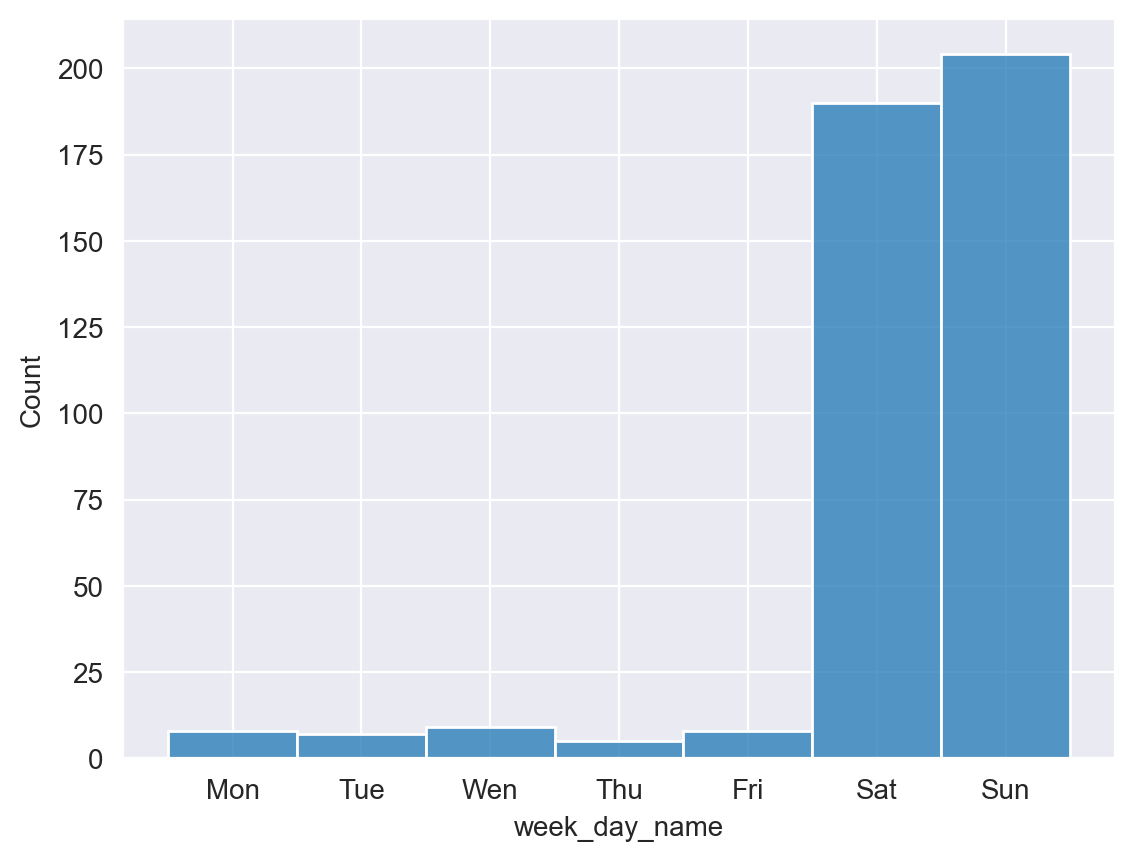

In [8]:
week_day_dict = {
    0:"Mon",
    1:"Tue",
    2:"Wen",
    3:"Thu",
    4:"Fri",
    5:"Sat",
    6:"Sun"
}

data['week_day_name'] = data['week_day'].map(week_day_dict)

sns.histplot(
    data=data[(data['Income'] == 0) & (data['Outcome'] == 0)].sort_values(by='week_day'),
    x='week_day_name')

__Вывод:__

Видно, что нули чаще всего встречаются по выходным дням. Однако по воскресеньям - чаще. Скорее всего это были рабочие субботы. Надо проверить все выходные.

In [9]:
#!pip install holidays

In [10]:
import holidays
cal_h = holidays.RU()

def is_holiday(date):
    return date in cal_h

data['is_holiday'] = data['Date'].apply(lambda x: is_holiday(x))

In [11]:
zero_data = data[(data['Income'] == 0) & (data['Income'] == 0)]
non_zero_data = data[(data['Income'] != 0) & (data['Income'] != 0)]

print(f"Percent of zeros: {round(len(zero_data)/len(data), 3) * 100} %")

Percent of zeros: 29.2 %


In [25]:
# рабочие дни по которым не работаем
zero_data[
    ~(
    (zero_data['is_holiday']) |\
    (zero_data['week_day_name'].isin(['Sat', 'Sun']))
    )

]

,Timestamp,Income,Outcome,Balance,Date,week_day,week_day_name,is_holiday
305,2017-11-10,0.0,0.0,0.0,2017-11-10,4,Fri,False
639,2018-10-10,0.0,0.0,0.0,2018-10-10,2,Wen,False
1262,2020-06-24,0.0,0.0,0.0,2020-06-24,2,Wen,False


In [26]:
# праздники по которым работаем
non_zero_data[
    non_zero_data['is_holiday']
]

,Timestamp,Income,Outcome,Balance,Date,week_day,week_day_name,is_holiday
46,2017-02-24,0.058229,5.135249e-03,0.053094,2017-02-24,4,Fri,True
359,2018-01-03,0.006585,7.369691e-03,-0.000785,2018-01-03,2,Wen,True
360,2018-01-04,0.000772,0.000000e+00,0.000772,2018-01-04,3,Thu,True
361,2018-01-05,0.000741,6.567672e-07,0.000741,2018-01-05,4,Fri,True
362,2018-01-06,0.011093,1.179436e-01,-0.106851,2018-01-06,5,Sat,True
424,2018-03-09,0.000012,2.859568e-05,-0.000017,2018-03-09,4,Fri,True
476,2018-04-30,0.004996,0.000000e+00,0.004996,2018-04-30,0,Mon,True
478,2018-05-02,0.003981,0.000000e+00,0.003981,2018-05-02,2,Wen,True
518,2018-06-11,0.005591,0.000000e+00,0.005591,2018-06-11,0,Mon,True
721,2018-12-31,0.003636,4.623360e-07,0.003635,2018-12-31,0,Mon,True


In [22]:
# посмотрим на январские праздники
data[(data['Timestamp'].dt.month == 1) & (data['Timestamp'].dt.day.isin([x for x in range(10)]))]

,Timestamp,Income,Outcome,Balance,Date,week_day,week_day_name,is_holiday
0,2017-01-09,1.343028,1.487865e+00,-1.559036e-01,2017-01-09,0,Mon,False
357,2018-01-01,0.000000,0.000000e+00,0.000000e+00,2018-01-01,0,Mon,True
358,2018-01-02,0.000000,0.000000e+00,0.000000e+00,2018-01-02,1,Tue,True
359,2018-01-03,0.006585,7.369691e-03,-7.846192e-04,2018-01-03,2,Wen,True
360,2018-01-04,0.000772,0.000000e+00,7.715172e-04,2018-01-04,3,Thu,True
361,2018-01-05,0.000741,6.567672e-07,7.407582e-04,2018-01-05,4,Fri,True
362,2018-01-06,0.011093,1.179436e-01,-1.068507e-01,2018-01-06,5,Sat,True
363,2018-01-07,0.000000,0.000000e+00,0.000000e+00,2018-01-07,6,Sun,True
364,2018-01-08,0.000000,0.000000e+00,0.000000e+00,2018-01-08,0,Mon,True
365,2018-01-09,1.645868,2.212047e+00,-5.670239e-01,2018-01-09,1,Tue,False


__Выводы:__

* на январских праздниках не работаем только 1-го и 2-го
* за день и после 8 марта и 23 февраля, немиотря на праздники - не работаем

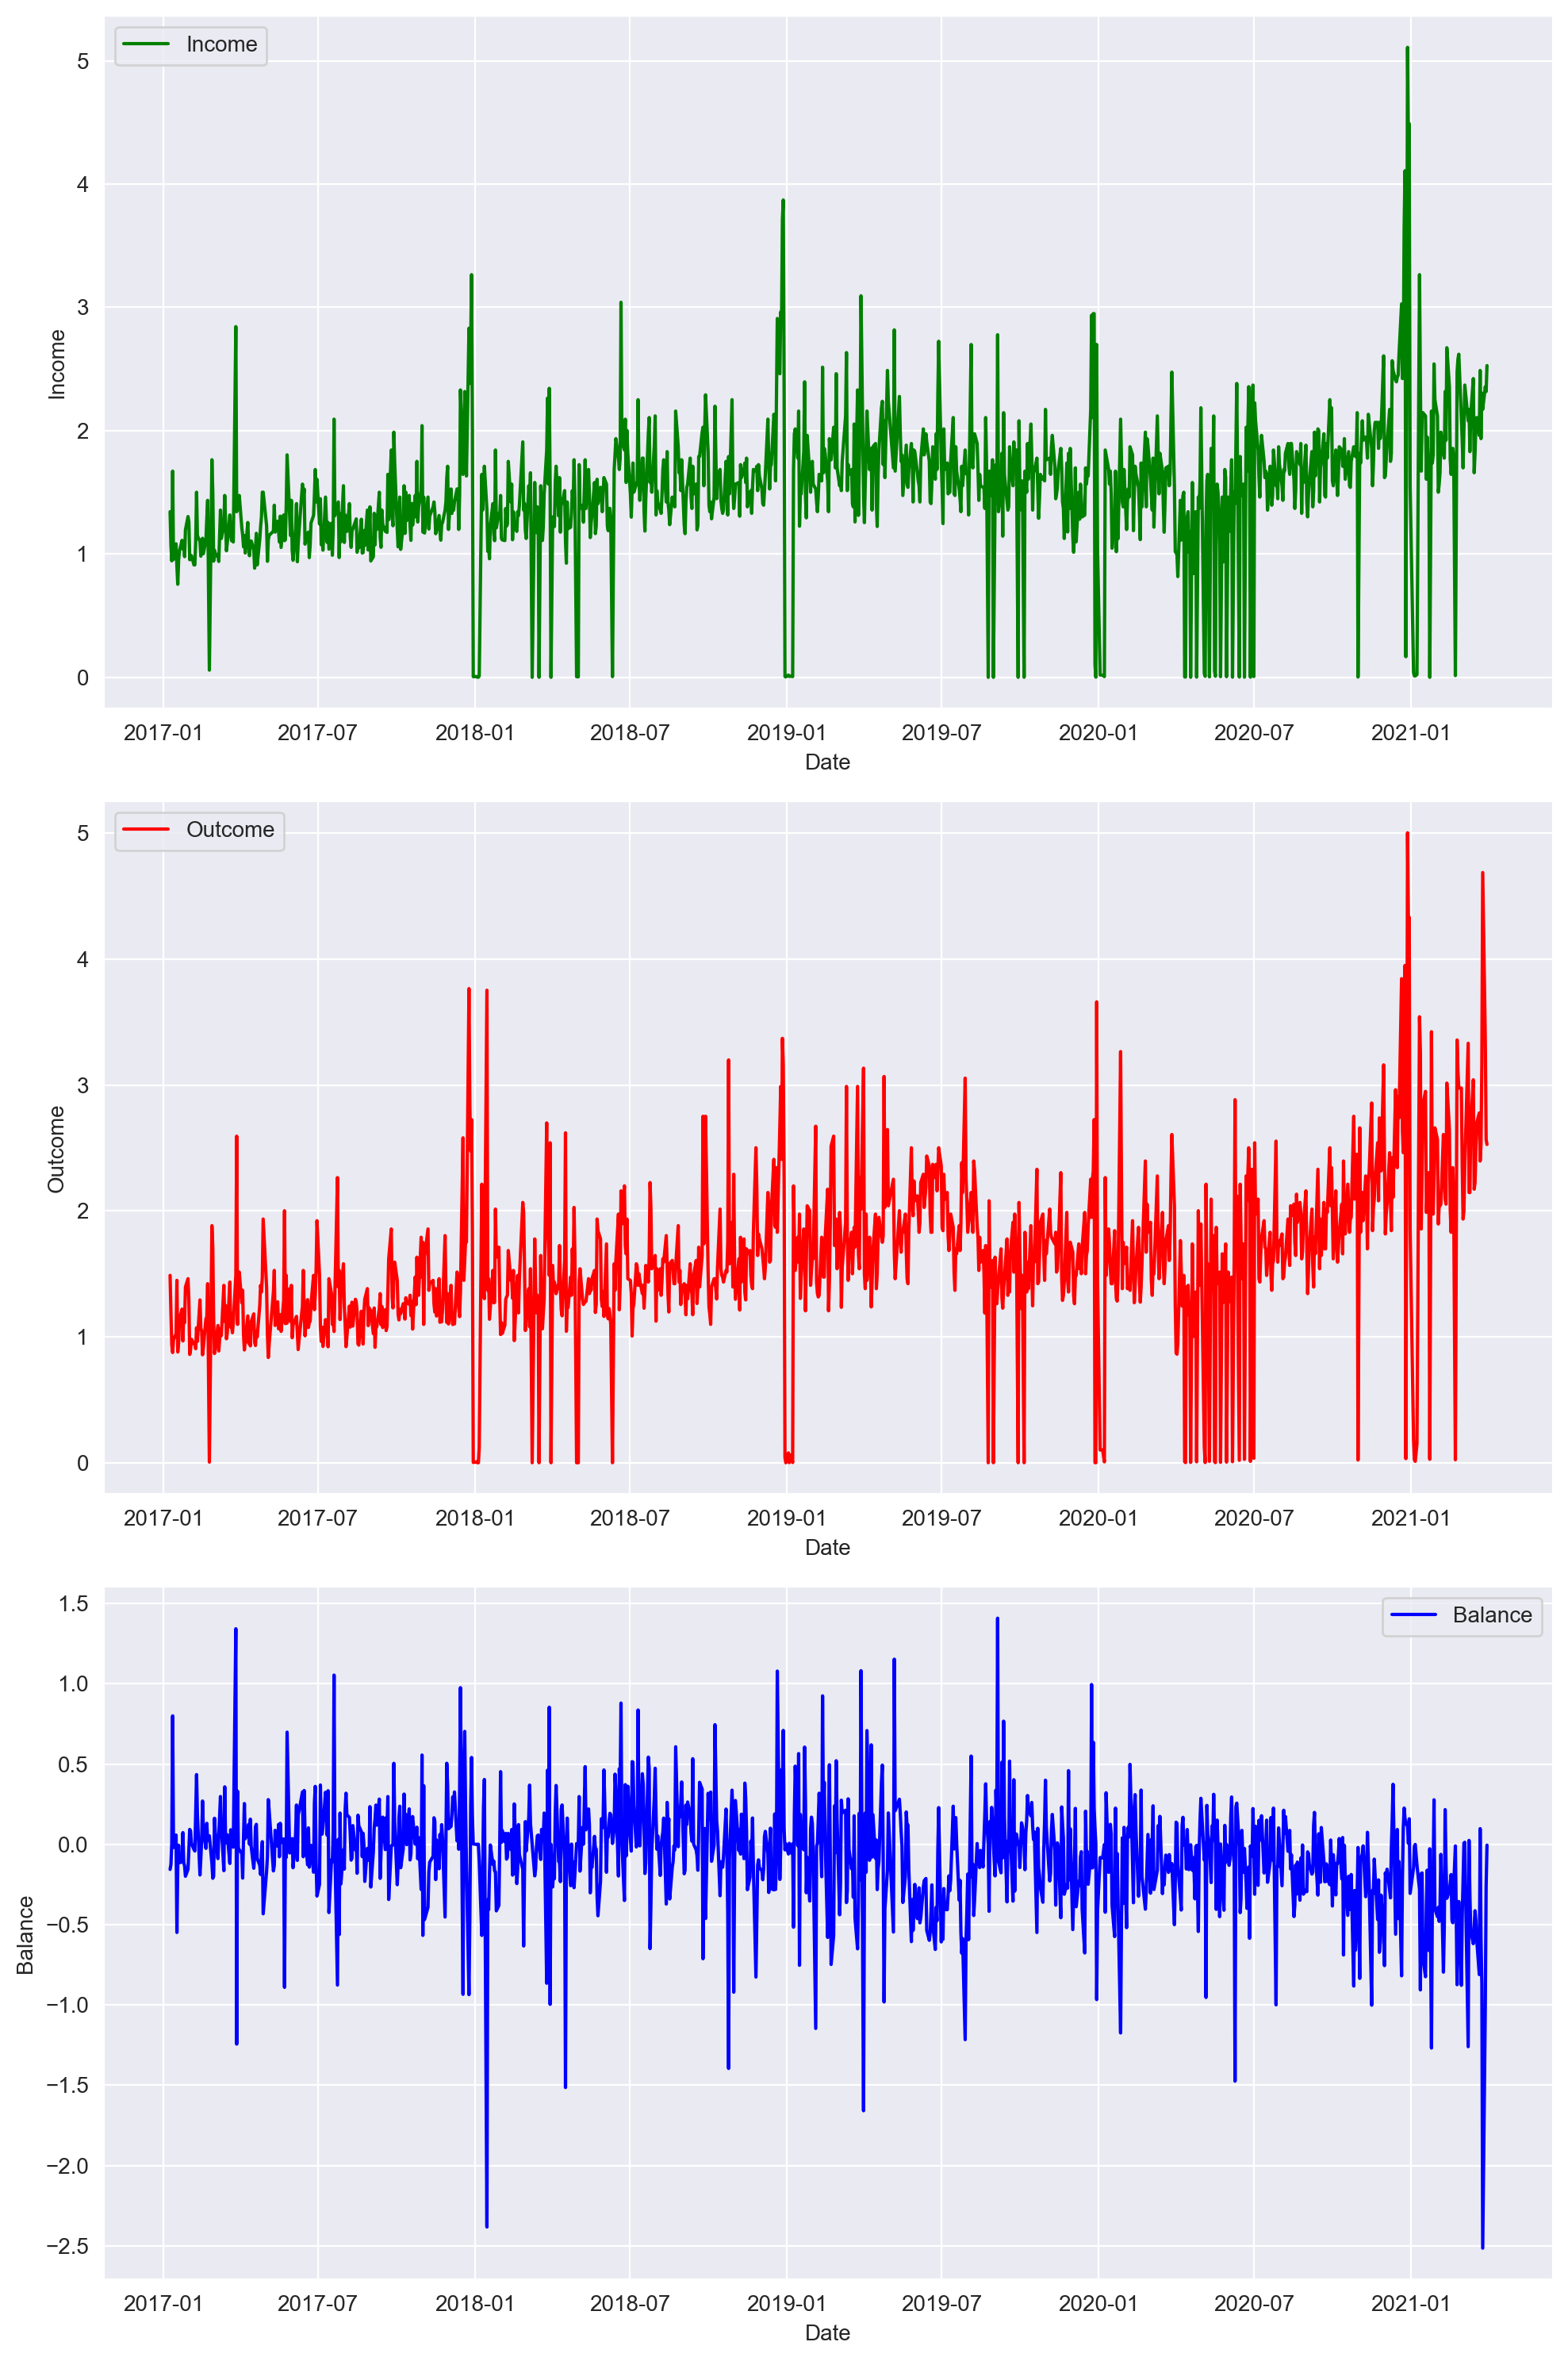

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

sns.lineplot(data=non_zero_data, x='Date', y='Income', ax=ax1, color='green', label='Income')
sns.lineplot(data=non_zero_data, x='Date', y='Outcome', ax=ax2, color='red', label='Outcome')
sns.lineplot(data=non_zero_data, x='Date', y='Balance', ax=ax3, color='blue', label='Balance')

plt.tight_layout()
plt.show()

In [31]:
non_zero_data.to_csv("../data/non_zero_data.xlsx")

____